DETAILED DESCRIPTIONS OF DATA FILES
==============================================

Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.


In [64]:
import pandas as pd
from collections import Counter
import numpy as np
from random import shuffle
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

In [4]:
def normalise(data):
    
    minimum = min(data)
    maximum = max(data)
    data = (data - minimum)/(maximum - minimum)
    return data

In [5]:
def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [6]:
def Matrixfactorization(R,P,Q,K,epochs,alpha,lamda,epsilon,bi,bu):
    
    errorold = 1e100
    rows = list(range(len(R)))
    cols = list(range(len(R[0])))
    shuffle(rows) #Shuffling for SGD
    shuffle(cols)
    for epoch in range(0,epochs):
        for row in rows:
            for col in cols:
                if R[row][col] > 0:
                    e = R[row][col] - np.dot(P[row,:],Q[:,col])
                    for k in range(0,K):
                        P[row][k] = P[row][k] - alpha * (-2 * e * Q[k][col] + 2 * lamda * P[row][k])
                        Q[k][col] = Q[k][col] - alpha * (-2 * e * P[row][k] + 2 * lamda * Q[k][col])
                        bi = bi + alpha * (e - lamda * bi)
                        bu = bu + alpha * (e - lamda * bu)
                        
        
        error = 0
        R_predicted = np.dot(P,Q)
        actual = R[R.nonzero()].flatten()
        pred = R_predicted[R.nonzero()].flatten()
        error = mean_squared_error(pred,actual) * len(actual)
        if error < 0:
            print(errorold)
            print("Converged")
            return Pold,Qold
        
        elif error > errorold:
            print("Converged")
            return Pold,Qold
        
        elif error < epsilon:
            print("Converged")
            return P,Q
        Pold = P
        Qold = Q
        errorold = error
        
    return P,Q

In [227]:
userratingdata = pd.read_csv("ml-100k/u.data",header=None,delimiter="\t")
userratingdata.columns = ["UserID","ItemID","Rating","Timestamp"]
userratingdata = userratingdata.drop(columns="Timestamp")
normaliseddata = normalise(userratingdata.Rating)
train = userratingdata.sample(frac=0.7)
test = userratingdata.drop(userratingdata.index[train.index])

In [8]:
userratingdata.Rating = normaliseddata
userratingdata.sample(10)

,UserID,ItemID,Rating
51048,712,177,0.25
47878,546,977,1.00
86701,619,231,0.75
53749,654,100,0.00
94577,758,541,0.75
7630,293,8,0.50
88747,494,204,1.00
6996,60,485,0.75
1366,58,709,1.00
1086,193,1078,0.75


In [9]:
def get_matrix(data):
    
    arr_train = np.array(data)
    rows, row_pos = np.unique(arr_train[:, 0], return_inverse=True)
    cols, col_pos = np.unique(arr_train[:, 1], return_inverse=True)
    matrix= np.zeros((len(rows), 1682), dtype=arr_train.dtype)
    matrix[row_pos, col_pos] = arr_train[:, 2]
    return matrix

In [17]:
def Predict(data,k,epochs,al,lam,epsilon,bi,bu):
    
    R = get_matrix(data)
    P = np.random.rand(len(R),k)
    Q = np.random.rand(k,len(R[0]))
    P,Q = Matrixfactorization(R,P,Q,k,epochs,al,lam,epsilon,bi,bu)
    return P,Q
    

In [52]:
Krange = [2,5,7,10]
epochs = 5
bu = 0
bi = 0
alpha = [1e-4,0.01,1e-8]
lamda = [1e-5,0.01,1e-4]
epsilon = 1e-3
kfold = 3
split = round(len(train) / 3)
min_RMSE = 1e100
best_params = dict()

for k in Krange:
    for al in alpha:
        for lam in lamda:
            print("K: ",k,"\tAlpha: ",al,"\tLamda: ",lam)
            RMSE_fold = list()
            
            for i in range(kfold):
                
                start = i*split
                index = train.index
                test_index = index [start:start+split]
                fold_test = train.ix[test_index.values]
                fold_train = train.drop(fold_test.index)
                P,Q = Predict(fold_train,k,epochs,al,lam,epsilon,bi,bu)
                R_predicted = np.dot(P,Q)
                R_test = get_matrix(fold_test)
                RMSE_fold.append(get_rmse(R_predicted,R_test))
                
            RMSE = np.average(RMSE_fold)
            print("RMSE: ",RMSE,"\n")
            if min_RMSE > RMSE:
                min_RMSE = RMSE
                optimum_params = dict(latentfeatures=k,alpha = al, lamda = lam)
                best_params = optimum_params
                print(best_params)

K:  2 	Alpha:  0.0001 	Lamda:  1e-05
RMSE:  3.022208128114382 

{'alpha': 0.0001, 'latentfeatures': 2, 'lamda': 1e-05}
K:  2 	Alpha:  0.0001 	Lamda:  0.01
RMSE:  3.038228551233049 

K:  2 	Alpha:  0.0001 	Lamda:  0.0001
RMSE:  3.02604171194074 

K:  2 	Alpha:  0.01 	Lamda:  1e-05
RMSE:  1.2242724846553263 

{'alpha': 0.01, 'latentfeatures': 2, 'lamda': 1e-05}
K:  2 	Alpha:  0.01 	Lamda:  0.01
RMSE:  1.2245927973161639 

K:  2 	Alpha:  0.01 	Lamda:  0.0001
RMSE:  1.2239337714839393 

{'alpha': 0.01, 'latentfeatures': 2, 'lamda': 0.0001}
K:  2 	Alpha:  1e-08 	Lamda:  1e-05
RMSE:  3.2532689085223296 

K:  2 	Alpha:  1e-08 	Lamda:  0.01
RMSE:  3.247778008032291 

K:  2 	Alpha:  1e-08 	Lamda:  0.0001
RMSE:  3.251486215852328 

K:  5 	Alpha:  0.0001 	Lamda:  1e-05
RMSE:  2.266134034789847 

K:  5 	Alpha:  0.0001 	Lamda:  0.01
RMSE:  2.276887931537546 

K:  5 	Alpha:  0.0001 	Lamda:  0.0001
RMSE:  2.2727292267916885 

K:  5 	Alpha:  0.01 	Lamda:  1e-05
RMSE:  1.2118074584190526 

{'alpha': 0.

In [13]:
best_params = dict(alpha = 0.01,latentfeatures = 7, lamda = 0.01)
best_params

{'alpha': 0.01, 'lamda': 0.01, 'latentfeatures': 7}

In [14]:
rmse = [3.022208128114382,3.038228551233049,3.02604171194074,1.2242724846553263,1.2245927973161639,1.2239337714839393,1.2239337714839393,
       3.2532689085223296,3.247778008032291,3.251486215852328,2.266134034789847,2.276887931537546,2.2727292267916885,1.2118074584190526,
        1.208374750403612,1.2103198857099038,2.5914648822972746,2.596481730270084,2.5936623422603287,1.874644132046199,1.8817984085598287,1.8863202427860652,1.2086290096434407,1.207410595582976,1.2123971444650112 ,2.2130767272264777,2.1833483757199366,2.1999609600791565,1.4637962870095942 ,1.477795369532516 ,1.4655662905065718 ,1.2148930825945519 ,1.2095774638711367 ,1.214615628903279 ,1.6650474441178647 ,1.684198672780772 ,1.6802266372799517]
min(rmse)

1.207410595582976

Text(0, 0.5, 'RMSE')

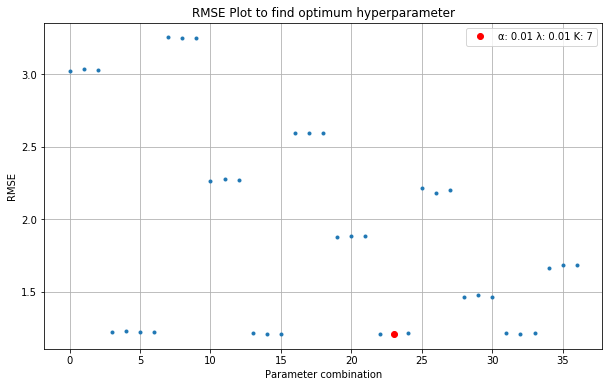

In [15]:
plt.figure(figsize=(10,6))
plt.plot(rmse,".")
plt.plot(rmse.index(min(rmse)),min(rmse),'ro',label =  "α: 0.01 λ: 0.01 K: 7")
plt.legend()
plt.grid()
plt.title("RMSE Plot to find optimum hyperparameter")
plt.xlabel("Parameter combination")
plt.ylabel("RMSE")

In [24]:
k = best_params['latentfeatures']
al = best_params['alpha']
lam = best_params['lamda']
epochs = 5
bi = 0
bu = 0
epsilon = 1e-3
P,Q = Predict(train,k,epochs,al,lam,epsilon,bi,bu)
R_predicted = np.dot(P,Q)
R_test = get_matrix(test)
RMSE_test = get_rmse(R_predicted,R_test)

1.156516884048022

In [42]:
test["Predicted"] = R_predicted[R_test.nonzero()]
test.sample(10)

,UserID,ItemID,Rating,Predicted
10261,270,288,5,3.967640
77333,597,294,4,3.260520
73254,749,584,3,3.245168
34122,65,735,4,3.764370
65574,870,181,4,3.572247
61969,643,505,4,3.737900
83093,347,147,4,3.378994
59131,717,358,2,2.985608
2190,158,190,5,3.513005
93925,892,228,3,4.100046


In [78]:
data = get_matrix(userratingdata)
model = NMF(n_components=10,solver='cd',alpha = 0.01,max_iter=10,l1_ratio=0.01,verbose=1)
W = model.fit_transform(data)
H = model.components_

violation: 1.0
violation: 0.42074003171835245
violation: 0.32002991095652117
violation: 0.24377646966184302
violation: 0.19547113706107727
violation: 0.16041815572094537
violation: 0.13179182378133958
violation: 0.10971251622342877
violation: 0.09204809327934682
violation: 0.08015983582169128


In [79]:
get_rmse(get_matrix(train),np.dot(W,H))

0.7402794858253489

In [230]:
Krange = [2,5,7,10]
lamda = [1e-5,0.01,1e-4]
kfold = 3
split = round(len(train) / 3)
min_RMSE = 1e100
RMSE_list = list()
for k in Krange:
    for lam in lamda:
        print("K: ",k,"\tLamda: ",lam)
        RMSE_fold = list()
        for i in range(kfold):
            start = i*split
            index = train.index
            test_index = index [start:start+split]
            fold_test = train.ix[test_index.values]
            fold_train = train.drop(fold_test.index)
            R_train = get_matrix(fold_train)
            model = NMF(n_components=k,solver='cd',alpha = lam,max_iter=100,l1_ratio=0.01,verbose=1)
            W = model.fit_transform(R_train)
            H = model.components_
            R_predicted = np.dot(W,H)
            R_test = get_matrix(fold_test)
            RMSE_fold.append(get_rmse(R_predicted,R_test))
        RMSE = np.average(RMSE_fold)
        RMSE_list.append(RMSE)
        print("RMSE: ",RMSE,"\n")
        if min_RMSE > RMSE:
            min_RMSE = RMSE
            optimum_params = dict(latentfeatures=k,alpha = al, lamda = lam)
            best_params = optimum_params
            print(best_params)

K:  2 	Lamda:  1e-05
violation: 1.0
violation: 0.494592803920878
violation: 0.2983473104906922
violation: 0.2152143460026971
violation: 0.166457600216553
violation: 0.13346816531055763
violation: 0.11084238142476854
violation: 0.09394577524937014
violation: 0.08074722043640625
violation: 0.06948104674383215
violation: 0.06039481812711564
violation: 0.05251846508183017
violation: 0.04589202433216827
violation: 0.04028594870912491
violation: 0.035504258317366616
violation: 0.031548246911696824
violation: 0.028165787938783556
violation: 0.025233486387123003
violation: 0.022744924862259836
violation: 0.020545879188996734
violation: 0.018595096657214483
violation: 0.016872378081632
violation: 0.015330331111773782
violation: 0.01398977147735006
violation: 0.012796962021577225
violation: 0.011708929311489567
violation: 0.010716638699655875
violation: 0.009811734898197378
violation: 0.00900005609901565
violation: 0.008266560892174958
violation: 0.007591144497529329
violation: 0.006961817958940

violation: 0.0807540322826152
violation: 0.06948878460866022
violation: 0.06040198804886292
violation: 0.052527792244201225
violation: 0.04590144880033313
violation: 0.040295353114162734
violation: 0.035514422038393056
violation: 0.03155793315589869
violation: 0.028175548327585176
violation: 0.02524271527714153
violation: 0.0227537003667638
violation: 0.020555130395394743
violation: 0.018603948059165206
violation: 0.01688086787591401
violation: 0.015339090854972771
violation: 0.013998504458608743
violation: 0.012805174274464239
violation: 0.011716946060619621
violation: 0.010738034583911149
violation: 0.009821095264959692
violation: 0.009008427252625429
violation: 0.008275961540885099
violation: 0.007599436148458093
violation: 0.006969700466152761
violation: 0.006401936883041948
violation: 0.005884730970459441
violation: 0.005412074121846229
violation: 0.00497997608980468
violation: 0.004582884392440114
violation: 0.004217829840728012
violation: 0.0038806399544932912
violation: 0.00357

KeyboardInterrupt: 

In [220]:
best_params

{'alpha': 0.01, 'lamda': 1e-05, 'latentfeatures': 10}

Text(0, 0.5, 'RMSE')

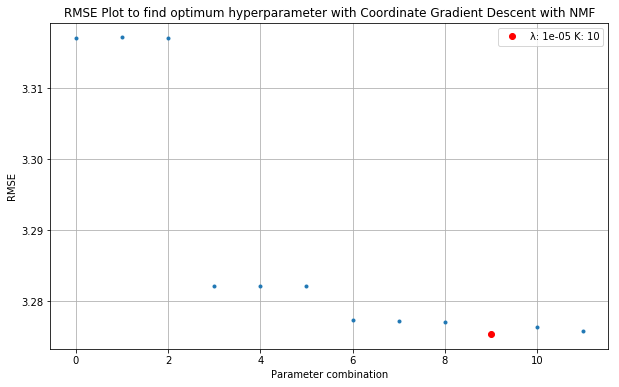

In [221]:
plt.figure(figsize=(10,6))
plt.plot(RMSE_list,".")
plt.plot(RMSE_list.index(min(RMSE_list)),min(RMSE_list),'ro',label =  "λ: 1e-05 K: 10")
plt.legend()
plt.grid()
plt.title("RMSE Plot to find optimum hyperparameter with Coordinate Gradient Descent with NMF")
plt.xlabel("Parameter combination")
plt.ylabel("RMSE")

In [231]:
data = get_matrix(train)
model = NMF(n_components=best_params['latentfeatures'],solver='cd',alpha = best_params['lamda'],max_iter=100,l1_ratio=0.01,verbose=1)
W = model.fit_transform(data)
H = model.components_
print("\n\nRMSE: ", get_rmse(get_matrix(test),np.dot(W,H)))

violation: 1.0
violation: 0.49217769628702346
violation: 0.2946051261935476
violation: 0.21118747104282337
violation: 0.16203318695142863
violation: 0.12955059070122932
violation: 0.10718019633001849
violation: 0.09076645989614561
violation: 0.0775795544537665
violation: 0.0665306064517011
violation: 0.057169497245420364
violation: 0.04935651407211485
violation: 0.04286875668417816
violation: 0.037344478741293465
violation: 0.03272091181710358
violation: 0.02880301098599167
violation: 0.025394847535458412
violation: 0.02236475192666389
violation: 0.019784262426639505
violation: 0.017586041031835125
violation: 0.015662721403751998
violation: 0.013972733487723954
violation: 0.012495490278955381
violation: 0.011194235569217687
violation: 0.010048685441785565
violation: 0.009035443105839217
violation: 0.008127502133078281
violation: 0.007317570285705622
violation: 0.006599279541548937
violation: 0.005958660904994312
violation: 0.005376168406423714
violation: 0.004856634570084466
violation:

In [236]:
np.dot(W,H)

array([[2.63531105, 1.05409906, 0.51871602, ..., 0.        , 0.        ,
        0.        ],
       [1.60829498, 0.15202298, 0.45114825, ..., 0.        , 0.        ,
        0.        ],
       [0.79210287, 0.07487298, 0.22219545, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71059545, 0.06716855, 0.19933152, ..., 0.        , 0.        ,
        0.        ],
       [0.98217482, 0.32875391, 0.21088593, ..., 0.        , 0.        ,
        0.        ],
       [1.81081902, 0.64635046, 0.37778539, ..., 0.        , 0.        ,
        0.        ]])

In [240]:
test["Predicted"] = R_predicted[R_test.nonzero()]
test.head(20)

,UserID,ItemID,Rating,Predicted2,Predicted
1,186,302,3,2.635311,2.635311
4,166,346,1,1.838889,1.838889
7,253,465,5,0.632801,0.632801
10,62,257,2,1.901789,1.901789
17,194,274,2,0.466068,0.466068
20,119,392,4,1.482819,1.482819
22,299,144,4,1.506350,1.506350
24,308,1,4,1.425606,1.425606
25,95,546,2,0.763572,0.763572
30,50,246,3,0.784256,0.784256


# Data Analysis

## Movie lens dataset 

In [9]:
userratingdata = pd.read_csv("ml-100k/u.data",header=None,delimiter="\t")
userratingdata.columns = ["UserID","ItemID","Rating","Timestamp"]

In [10]:
count = Counter(userratingdata.Rating)

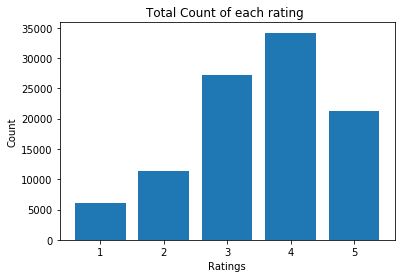

In [14]:
plt.bar(count.keys(),count.values())
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Total Count of each rating ")
plt.show()

Counter({'student': 196, 'other': 105, 'educator': 95, 'administrator': 79, 'engineer': 67, 'programmer': 66, 'librarian': 51, 'writer': 45, 'executive': 32, 'scientist': 31, 'artist': 28, 'technician': 27, 'marketing': 26, 'entertainment': 18, 'healthcare': 16, 'retired': 14, 'salesman': 12, 'lawyer': 12, 'none': 9, 'doctor': 7, 'homemaker': 7})


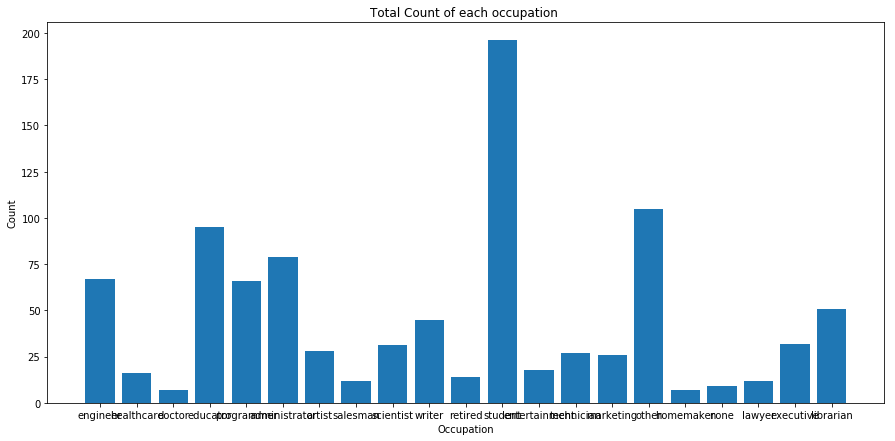

In [180]:
userinfo = pd.read_csv("ml-100k/u.user",header=None,delimiter = "|")
count = Counter(userinfo[3])
print(count)
plt.figure(figsize=(15,7))
plt.bar(count.keys(),count.values())
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Total Count of each occupation ")
plt.show()

In [167]:
occupation = pd.read_csv("ml-100k/u.occupation",header=None,delimiter = "|")
avgage = dict()
for i in occupation[0]:
    
    ocupation = i
    averageage = np.sum(userinfo[userinfo[3] == ocupation][1]) / Counter(userinfo[userinfo[3] == ocupation][3])[ocupation]
    avgage[ocupation]= round(averageage,2)

{'administrator': 38.75, 'writer': 36.31, 'educator': 42.01, 'programmer': 33.12, 'doctor': 43.57, 'artist': 31.39, 'other': 34.52, 'scientist': 35.55, 'salesman': 35.67, 'retired': 63.07, 'student': 22.08, 'homemaker': 32.57, 'healthcare': 41.56, 'marketing': 37.62, 'engineer': 36.39, 'entertainment': 29.22, 'none': 26.56, 'lawyer': 36.75, 'executive': 38.72, 'librarian': 40.0, 'technician': 33.15}


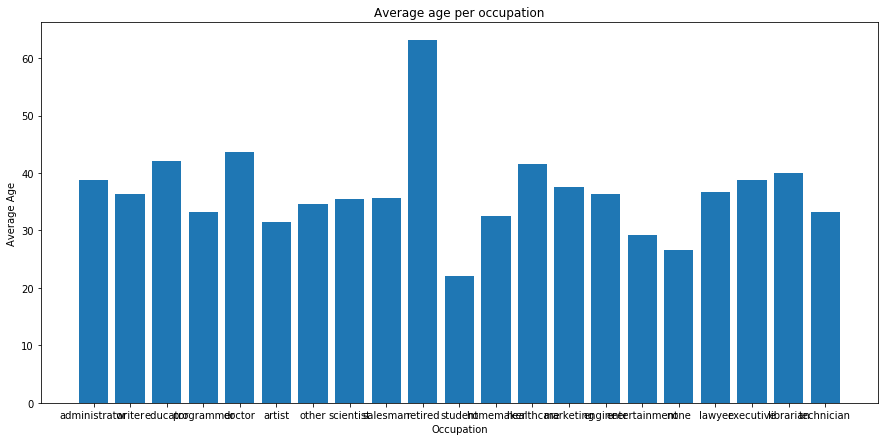

In [183]:
print(avgage)
plt.figure(figsize=(15,7))
plt.bar(avgage.keys(),avgage.values())
plt.xlabel("Occupation")
plt.ylabel("Average Age")
plt.title("Average age per occupation")
plt.show()


## Wine dataset 

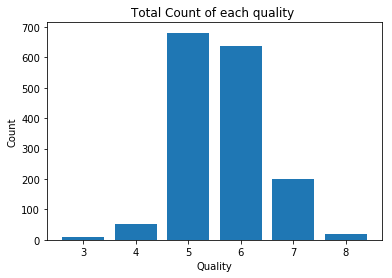

In [189]:
winedata = pd.read_csv("winequality-red.csv",delimiter=";",header=0)
count = Counter(winedata.quality)
plt.bar(count.keys(),count.values())
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Total Count of each quality ")
plt.show()

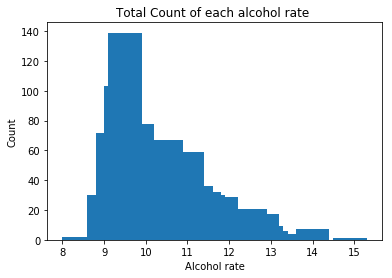

In [201]:
count = Counter(winedata.alcohol)
plt.bar(count.keys(),count.values())
plt.xlabel("Alcohol rate")
plt.ylabel("Count")
plt.title("Total Count of each alcohol rate ")
plt.show()

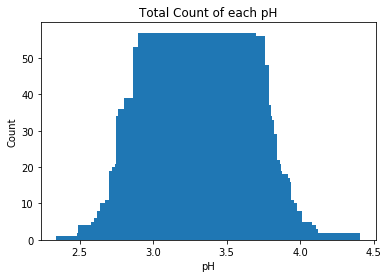

In [202]:
count = Counter(winedata.pH)
plt.bar(count.keys(),count.values())
plt.xlabel("pH")
plt.ylabel("Count")
plt.title("Total Count of each pH")
plt.show()

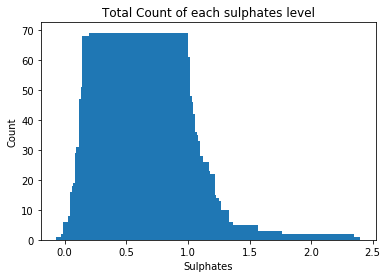

In [206]:

count = Counter(winedata.sulphates)
plt.bar(count.keys(),count.values())
plt.xlabel("Sulphates")
plt.ylabel("Count")
plt.title("Total Count of each sulphates level")
plt.show()

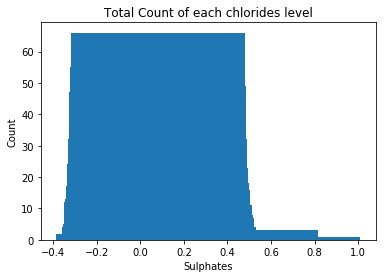

In [204]:
count = Counter(winedata.chlorides)
plt.bar(count.keys(),count.values())
plt.xlabel("Sulphates")
plt.ylabel("Count")
plt.title("Total Count of each chlorides level")
plt.show()